# Lab 4 - Aspect-Based Sentiment Analysis



---















In this session, we demonstrate how to deal with the aspect-based sentiment analysis (ABSA). You can find the whole task description from (https://aclanthology.org/D19-1654.pdf).
This task provides a review text dataset with aspect.
Given a review and an aspect, we need to classify the sentiment conveyed towards that aspect on a  three-point scale:   POSITIVE, NEUTRAL, and NEGATIVE.
This is a multi-class classification task, and it needs to analyze the text and its aspect. 

Same as before, we are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. You could modify the previous models to fit in the new task.

In [ ]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model

### Downloading and preprocessing data

Unlike the IMDB dataset that is included and preprocessed by the Keras, the dataset we will be using is the aspect-term sentiment analysis (ATSA) dataset, which consists of 5297 labeled reviews. These are split into 4,297 reviews for training and 500 reviews for testing and validation, respectively. 

For ATSA, the annotators extract aspect terms in the sentences and label the sentiment polarities with respect to the  aspect  terms.   The  sentences  that  consist  of only one aspect term or multiple aspects with the same  sentiment  polarities  are  deleted.  ATSA also provides the start and end positions in a sentence for each aspect term.

In [ ]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


In [ ]:
# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
val = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))

Training entries: 11186
Test entries: 1336


We now can start playing around with the data, let’s first see some examples:

In [ ]:
print("SENTENCE \t ASPECT \t LABEL \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABEL 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


We could use this dataset to try an "unknown aspect" task, if we assume that the ASPECT, LABEL and START/END-INDEX fields are what the model must predict. But here we will attempt a simpler "known aspect" task: we will assume that we know ASPECT and START/END-INDEX and the model must just predict the LABEL for a given combination of aspect and sentence.

First, build a vocabulary based on the training dataset. 

In [ ]:
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in train:
  text_tokens = text_to_word_sequence(example[0])
  aspect_tokens = text_to_word_sequence(example[1])
  voc.extend(aspect_tokens)
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))
print(word_index['setup'])

7894
7898
219


According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the review text and aspect words to word tokens and integers separately:


In [ ]:
# Please write your code to generate the following data
x_train_review=[]
x_train_aspect=[]
x_train_review_int=[]
x_train_aspect_int=[]
for sample in train:
    x_train_review.append(text_to_word_sequence(sample[0]))
    x_train_aspect.append(text_to_word_sequence(sample[1]))
    x_train_review_int.append([word_index[x] for x in text_to_word_sequence(sample[0])])
    x_train_aspect_int.append([word_index[x] for x in text_to_word_sequence(sample[1])])


x_dev_review = []
x_dev_aspect = []
x_dev_review_int = []
x_dev_aspect_int = []

for sample in val:
  review_int = [] 
  aspect_int = []
  x_dev_review.append(text_to_word_sequence(sample[0]))
  x_dev_aspect.append(text_to_word_sequence(sample[1]))
  
  for word in text_to_word_sequence(sample[0]): 
    if word in word_index.keys():
      review_int.append(word_index[word])
    else:
      review_int.append(word_index["<UNK>"])# there might be some unseen words in the validation set
  x_dev_review_int.append(review_int)
  for word in text_to_word_sequence(sample[1]):
    if word in word_index.keys():
      aspect_int.append(word_index[word])
    else:
      aspect_int.append(word_index["<UNK>"])
  x_dev_aspect_int.append(aspect_int)

x_test_review = []
x_test_aspect = []
x_test_review_int = []
x_test_aspect_int = []
for sample in test:
  review_int = [] 
  aspect_int = []
  x_test_review.append(text_to_word_sequence(sample[0]))
  x_test_aspect.append(text_to_word_sequence(sample[1]))
  
  for word in text_to_word_sequence(sample[0]): 
    if word in word_index.keys():
      review_int.append(word_index[word])
    else:
      review_int.append(word_index["<UNK>"])# there might be some unseen words in the test set
  x_test_review_int.append(review_int)
  for word in text_to_word_sequence(sample[1]):
    if word in word_index.keys():
      aspect_int.append(word_index[word])
    else:
      aspect_int.append(word_index["<UNK>"])
  x_test_aspect_int.append(aspect_int)


# If use the previous word_index, you can get a print result like:
assert len(x_train_aspect) == len(train)
assert len(x_train_aspect) == len(x_train_aspect_int)
assert len(x_test_aspect) == len(test)
assert len(x_test_aspect) == len(x_test_aspect_int)
print("x_train_review[0]:")
print(x_train_review[0])
print("x_train_aspect[0]:")
print(x_train_aspect[0])
print("x_train_review_int[0]:")
print(x_train_review_int[0])
print("x_train_aspect_int[0]:")
print(x_train_aspect_int[0])

x_train_review[0]:
['the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
x_train_aspect[0]:
['decor']
x_train_review_int[0]:
[814, 3155, 6779, 7057, 983, 6816, 2806, 2251, 6836, 4954, 3104, 2189, 3897, 6730, 2917, 3290, 3577]
x_train_aspect_int[0]:
[3155]


We use 4 to represent "positive", 2 for "neutral", and 1 for "negative". Then we can convert the lables to numbers.

In [ ]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y
  
y_train = label2int(train)
y_dev = label2int(val)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost done the data preprocessing. Unlike the previous lab, there are two x (review and aspect) to input the model in here. The easiest way is to combine the review and aspect into one sentence and then input it into the model. Thus we can use the previous model directly.

(This means our model is similar to a simplified version of the Vo & Zhang model from the lectures: we have an input sequence containing an aspect embedding paired with the sentence word embeddings (but not separating into left & right sentence context as Vo & Zhang do).

In [ ]:
# Please write your code to combine the x_*_review and x_*_aspect into the following varibles
# your code goes here
# Tips: 
# 1) We can use the special token <START> to concatenate the reviews and aspects.
# 2) After combine them, do not foget to pad the sequences.
from keras.preprocessing.sequence import pad_sequences
x_train=[]
x_train_int=[]
x_dev=[]
x_dev_int=[]
x_test=[]
x_test_int=[]
for index,sample in enumerate(x_train_review):
    x_train.append(x_train_aspect[index]+['<START>']+sample)
for index,sample in enumerate(x_train_review_int):
    x_train_int.append(x_train_aspect_int[index]+[1]+sample)

for index,sample in enumerate(x_dev_review):
    x_dev.append(x_dev_aspect[index]+['<START>']+sample)
for index,sample in enumerate(x_dev_review_int):
    x_dev_int.append(x_dev_aspect_int[index]+[1]+sample)

for index,sample in enumerate(x_test_review):
    x_test.append(x_test_aspect[index]+['<START>']+sample)
for index,sample in enumerate(x_test_review_int):
    x_test_int.append(x_test_aspect_int[index]+[1]+sample)




# adding padding 
MAX_SEQUENCE_LENGTH = 128

x_train_pad = pad_sequences(x_train_int,
                            value=word_index["<PAD>"],
                            padding='post',
                            maxlen=MAX_SEQUENCE_LENGTH)
x_dev_pad =pad_sequences(x_dev_int,
                            value=word_index["<PAD>"],
                            padding='post',
                            maxlen=MAX_SEQUENCE_LENGTH)
x_test_pad =pad_sequences(x_test_int,
                            value=word_index["<PAD>"],
                            padding='post',
                            maxlen=MAX_SEQUENCE_LENGTH)


# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train[0])
print(x_train_int[0])
print("After paded:")
print(x_train_pad[0])

Before paded:
['decor', '<START>', 'the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
[3155, 1, 814, 3155, 6779, 7057, 983, 6816, 2806, 2251, 6836, 4954, 3104, 2189, 3897, 6730, 2917, 3290, 3577]
After paded:
[3155    1  814 3155 6779 7057  983 6816 2806 2251 6836 4954 3104 2189
 3897 6730 2917 3290 3577    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


#Model 1: Previous models without pre-trained word embeddings

## Model 1-1: Neural bag of words without pre-trained word embeddings

Now we use the model2 in lab4 to deal with our task. However, the previous model works only for the binary classification task. Therefore, we need to modify the output layer to fix the multi-class problem. You can read this tutorial for more details: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [ ]:
! pip install plot_keras_history
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=d607fab1050ee62c3a087c45f9d191f327b20f20cb074943ed6cc789c2774ea2
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=af57860a5202cb6e0fb3efe1b24b795057d5cb9f6d4a038bcba4cf5614b7ba4c
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=22989b61d76f95eacf17aca70a750489af1e4fc7e566dc0ce0a8f51953ba1570
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 128, 100)          1118600   
                                                                 
 global_average_pooling1d_7   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 16)                1616      
                                                                 
 dense_15 (Dense)            (None, 3)                 51        
                                                                 
Total params: 1,120,267
Trainable params: 1,120,267
Non-trainable params: 0
_________________________________________________

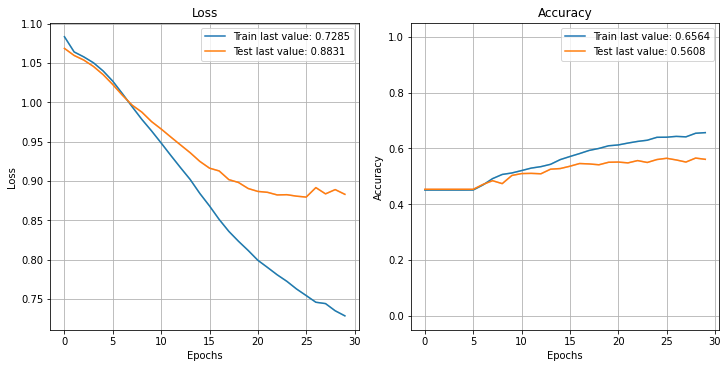

In [ ]:
# your code goes here
# Tips: The activation function of the output layer is softmax.
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(embeddings_initializer="glorot_uniform",
                            output_dim=EMBEDDING_SIZE,
                            input_dim=len(x_train_pad),
                            mask_zero=False)(input_layer)

avg_pooling_layer = GlobalAveragePooling1D()(embedding_layer)
dense_hidden_layer = Dense(16, activation='relu')(avg_pooling_layer)
output_dense_layer = Dense(3, activation='softmax')(dense_hidden_layer)

model1 = Model(inputs= input_layer, outputs= output_dense_layer)
model1.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model1.summary()

history = model1.fit(x_train_pad,
           y_train,
           epochs = 30,
           batch_size=512,
           validation_data=(x_dev_pad,y_dev),
           verbose=1)
results = model1.evaluate(x_test_pad, y_test)
print(results)

plot_history(history.history, path="std.png")
plt.show()

The accuracy of lab3 model2 in this task is around 46%. If you use the "glorot_uniform" initialization method, the accuracy can reach around 55%.

**I reached 59% accuracy.**

##  Model 1-2: CNN or LSTM without pre-trained word embeddings

Please try one more model (CNN or LSTM) without pre-trained word embeddings in here:

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 128, 100)          1118600   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_16 (Dense)            (None, 16)                1616      
                                                                 
 dense_17 (Dense)            (None, 3)                 51        
                                                                 
Total params: 1,200,667
Trainable params: 1,200,667
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [==============================]

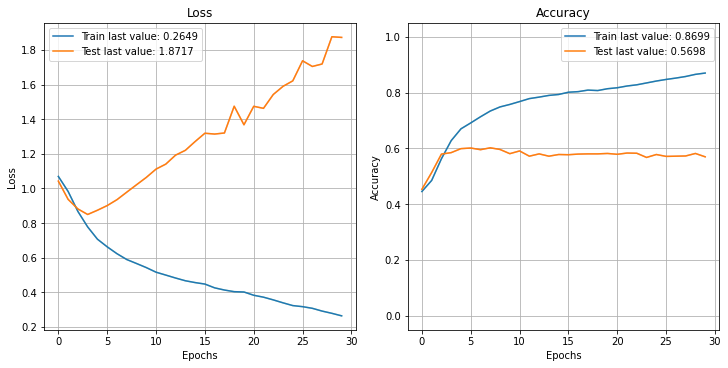

In [ ]:
# Try CNN or LSTM without pre-trained word embeddings in here:
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100

from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(mask_zero = True,
                            input_length = MAX_SEQUENCE_LENGTH,
                            input_dim = len(x_train_pad),
                            output_dim = EMBEDDING_SIZE,
                            embeddings_initializer='glorot_uniform')(input_layer)
lstm_layer = LSTM(EMBEDDING_SIZE,
                  return_sequences=False)(embedding_layer)
hidden_dense_layer = Dense(16, activation='relu')(lstm_layer)
output_dense_layer = Dense(3, activation='softmax')(hidden_dense_layer)
model2 = Model(inputs= input_layer, outputs=output_dense_layer)
model2.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model2.summary()

history = model2.fit(x_train_pad,
           y_train,
           epochs = 30,
           batch_size=512,
           validation_data=(x_dev_pad,y_dev),
           verbose=1)
results = model2.evaluate(x_test_pad, y_test)
print(results)

plot_history(history.history, path="std.png")
plt.show()


CNN

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 128, 100)          1118600   
                                                                 
 conv1d_1 (Conv1D)           (None, 123, 100)          60100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_20 (Dense)            (None, 16)                1616      
                                                                 
 dense_21 (Dense)            (None, 3)                 51        
                                                          

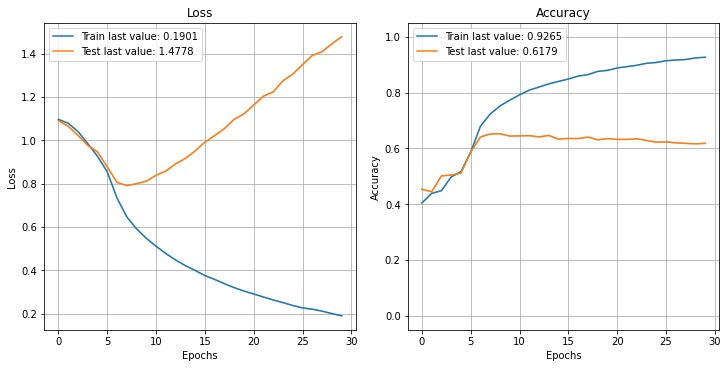

In [ ]:
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100

from keras.layers import Input, Embedding, Dense, Conv1D, Lambda
from keras.models import Model

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(mask_zero = True,
                            input_length = MAX_SEQUENCE_LENGTH,
                            input_dim = len(x_train_pad),
                            output_dim = EMBEDDING_SIZE,
                            embeddings_initializer='glorot_uniform')(input_layer)
conv_layer = Conv1D(EMBEDDING_SIZE, 6)(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
hidden_dense_layer = Dense(16, activation='relu')(pooling_layer)
output_dense_layer = Dense(3, activation='softmax')(hidden_dense_layer)
model3 = Model(inputs= input_layer, outputs=output_dense_layer)
model3.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model3.summary()

history = model3.fit(x_train_pad,
           y_train,
           epochs = 30,
           batch_size=512,
           validation_data=(x_dev_pad,y_dev),
           verbose=1)
results = model3.evaluate(x_test_pad, y_test)
print(results)

plot_history(history.history, path="std.png")
plt.show()

CNN does better. 

# Model 2: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-03-08 21:34:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-08 21:34:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-08 21:34:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


### Convert the data to GLOVE word index

The index in our vocabulary is different from that in GLOVE. For example, the word "you" corresponds to 394475 in GLOVE, while it corresponds to another index in our vocabulary. Thus we can not directly use the index data in the last section. We convert them from text tokens to GLOVE word index.

In [ ]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

394475
you
7331


In [ ]:
def returnGloveLike(inputDocs):
    glove_turned = []
    for doc in inputDocs:
        Gloved = []
        for word in doc:
            if word in wordToIndex.keys():
                glove_int = wordToIndex[word]
            else:
                glove_int = 2
            Gloved.append(glove_int)
        glove_turned.append(Gloved)
    return glove_turned    


In [ ]:
# Please write your code to generate the following data
x_train_review_glove = returnGloveLike(x_train_review)
x_train_aspect_glove = returnGloveLike(x_train_aspect)

x_dev_review_glove = returnGloveLike(x_dev_review)
x_dev_aspect_glove = returnGloveLike(x_dev_aspect)

x_test_review_glove = returnGloveLike(x_test_review)
x_test_aspect_glove = returnGloveLike(x_test_aspect)

# your code goes here


# You should get a print result like:
assert len(x_train_review_glove) == len(train)
assert len(x_train_aspect_glove) == len(x_train_aspect_int)
assert len(x_test_review_glove) == len(test)
assert len(x_test_aspect_glove) == len(x_test_aspect_int)
print("x_train_review_glove[0]:")
print(x_train_review_glove[0])
print("x_train_aspect_glove[0]:")
print(x_train_aspect_glove[0])

x_train_review_glove[0]:
[357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
x_train_aspect_glove[0]:
[118926]


As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [ ]:
# Please write your code to combine the x_*_review_glove and x_*_aspect_glove into the following varibles
# x_train_glove
# x_dev_glove
# x_test_glove

# Tips: 
# 1) There is no <START> token in GLOVE. Here we can use integer 1 to concatenate.
# 2) After combine them, do not foget to pad the sequences.

#######################TODO: REMOVE FOLLOWING CODE####################
def combine_x(aspect, review):
    return [ aspect[index] + [1] + sample for index,sample in enumerate(review)]

x_train_glove = combine_x(x_train_aspect_glove,x_train_review_glove)
x_dev_glove   = combine_x(x_dev_aspect_glove  ,x_dev_review_glove)
x_test_glove  = combine_x(x_test_aspect_glove ,x_test_review_glove)


x_train_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)
x_train_pad_glove = np.array(x_train_pad_glove)
x_dev_pad_glove = np.array(x_dev_pad_glove)
x_test_pad_glove = np.array(x_test_pad_glove)
#######################TODO: REMOVE ABOVE CODE####################

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

Before paded:
[118926, 1, 357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
After paded:
[118926      1 357266 118926 192973 264550 338995  62065  51582  87775
 357354 151204  54718  53201 292136 231458 373317 151349 193716      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0

## Model 2-1: Neural bag of words using pre-trained word embeddings

We use model3-1 in lab4 to deal with this task.

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_24 (Dense)            (None, 16)                4816      
                                                                 
 dense_25 (Dense)            (None, 3)                 51        
                                                          

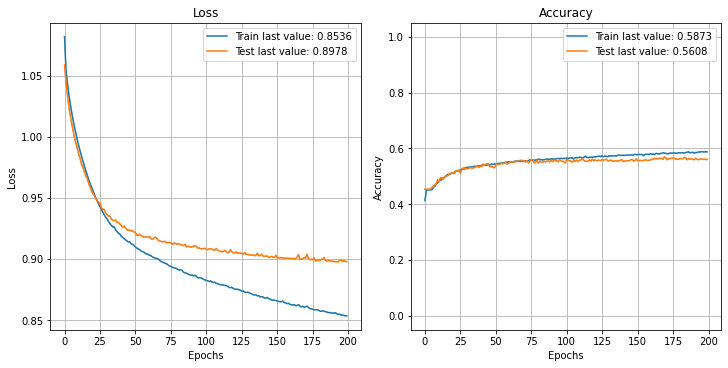

In [ ]:
# your code goes here
# Tips: Do not misuse the training data
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 300

from keras.layers import Input, Dense
from keras.models import Model

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16, activation='relu')(pooling_layer)
output_dense_layer = Dense(3, activation='softmax')(hidden_dense_layer)
model4 = Model(inputs= input_layer, outputs=output_dense_layer)
model4.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model4.summary()
history = model4.fit(x_train_pad_glove,
           y_train,
           epochs = 200,
           batch_size=512,
           validation_data=(x_dev_pad_glove,y_dev),
           verbose=1)
results = model4.evaluate(x_test_pad_glove, y_test)
print(results)

plot_history(history.history, path="std.png")
plt.show()

The accuracy is around 56%. In this version, the "glorot_uniform" initialization method does not improve model performance significantly.

##  Model 2-2: CNN or LSTM with pre-trained word embeddings

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_28 (Dense)            (None, 16)                1616      
                                                                 
 dense_29 (Dense)            (None, 3)                 51        
                                                                 
Total params: 120,162,367
Trainable params: 162,067
Non-trainable params: 120,000,300
______________________________________

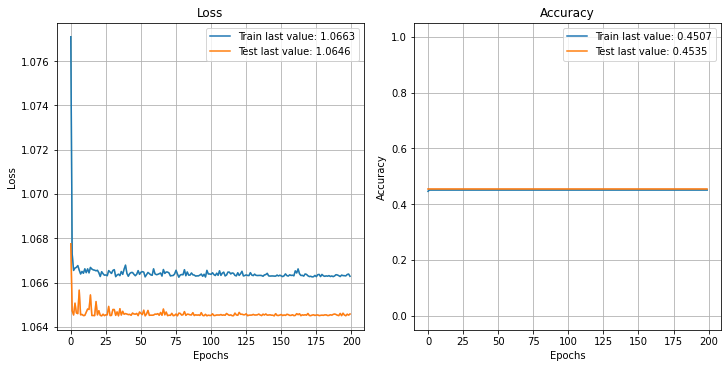

In [ ]:
# your code goes here
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100

from keras.layers import Input, Dense, LSTM
from keras.models import Model

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
LSTM_layer = LSTM(EMBEDDING_SIZE, return_sequences=False)(embedding_layer)
hidden_dense_layer = Dense(16, activation='relu')(LSTM_layer)
output_dense_layer = Dense(3, activation='softmax')(hidden_dense_layer)
model5 = Model(inputs= input_layer, outputs=output_dense_layer)
model5.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model5.summary()
history = model5.fit(x_train_pad_glove,
           y_train,
           epochs = 200,
           batch_size=512,
           validation_data=(x_dev_pad_glove,y_dev),
           verbose=1)
results = model5.evaluate(x_test_pad_glove, y_test)
print(results)

plot_history(history.history, path="std.png")
plt.show()



CNN

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 123, 100)          180100    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_30 (Dense)            (None, 16)                1616      
                                                                 
 dense_31 (Dense)            (None, 3)                 51 

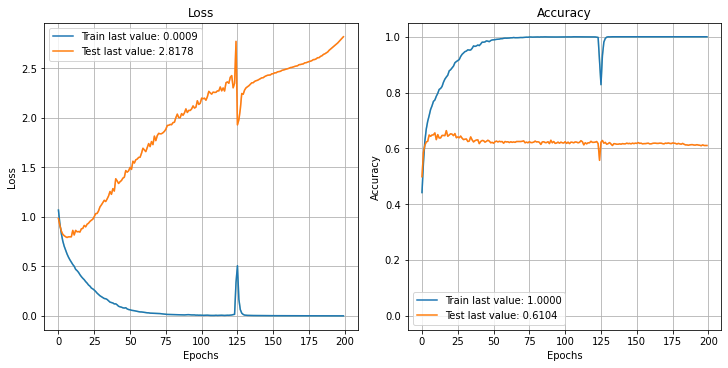

In [ ]:
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100

from keras.layers import Input, Dense, Conv1D, GlobalMaxPool1D
from keras.models import Model

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
conv_layer = Conv1D(EMBEDDING_SIZE,6)(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
hidden_dense_layer = Dense(16, activation='relu')(pooling_layer)
output_dense_layer = Dense(3, activation='softmax')(hidden_dense_layer)

model6 = Model(inputs= input_layer, outputs=output_dense_layer)
model6.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model6.summary()
history = model6.fit(x_train_pad_glove,
           y_train,
           epochs = 200,
           batch_size=512,
           validation_data=(x_dev_pad_glove,y_dev),
           verbose=1)
results = model6.evaluate(x_test_pad_glove, y_test)
print(results)

plot_history(history.history, path="std.png")
plt.show()

CNN has much better accuracy by far

#  Model 3: Model with multiple-input

Model 1 and 2 are copied from lab4. We build new models in this section. 

In models 1 and 2, we combine the reviews and aspects to input into the models. In model 3, we separately input these two data into the model and use different layers to analyze them. 

(This will give us a model similar to a simplified version of the Xue & Li model from the lectures - we have a separate paths through the network for the aspect embedding and the sentence, being combined - but we don't have to use gating like Xue & Li).

In [ ]:
# First of all, pad the review and aspect separately
x_train_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_review_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_review_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_review_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_train_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_aspect_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=16)

x_dev_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_aspect_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_test_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_aspect_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

## Model 3-1 Neural bag of words model with multiple-input

Model 3-1 needs you to modify the model 2-1 to be compatible with multiple-input.


You could find some tutorial examples from (https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/).

Please print the model summary and visualize it using vis_utils.

In [ ]:
# your code goes here
from keras.layers import Input, Embedding, Dense,concatenate
from keras.models import Model

MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100


input_layer_1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_layer_2 = Input(shape=(16,))

#Right side Input model
embedding_layer_1 = embeddingLayer(input_layer_1)
pooling_layer_1 = GlobalAveragePooling1DMasked()(embedding_layer_1)
output_dense_layer_1 = Dense(16, activation='relu')(pooling_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)

#Left side Input model
embedding_layer_2 = embeddingLayer(input_layer_2)
pooling_layer_2 = GlobalAveragePooling1DMasked()(embedding_layer_2)
output_dense_layer_2 = Dense(16, activation='relu')(pooling_layer_2)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

# concatenating output
combined_layer = concatenate([model_1.output, model_2.output])


output_dense_layer = Dense(3, activation='softmax')(combined_layer)

model_3_1 = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
model_3_1.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_3_1.summary()





Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_18[0][0]',               
                                                                  'input_19[0][0]']               
                                                                                                  
 global_average_pooling1d_maske  (None, 300)         0           ['GloVe_Embeddings[5][0]']

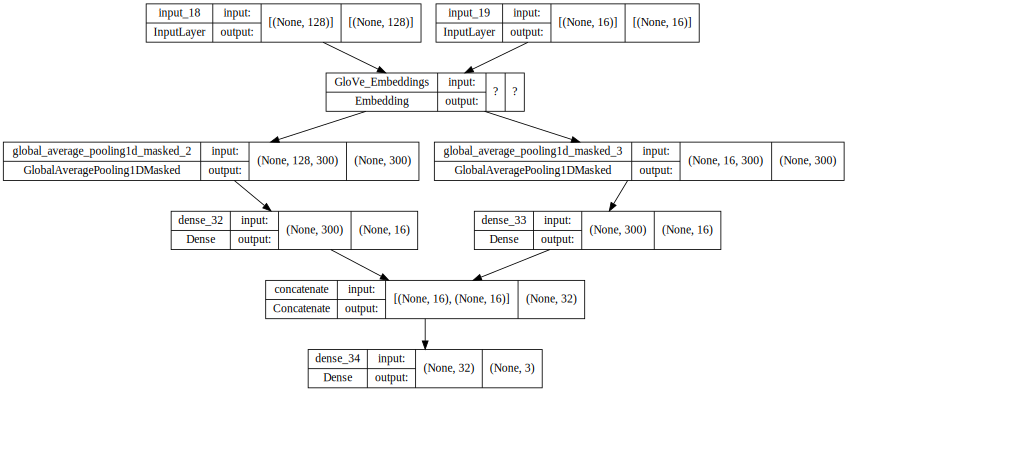

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_3_1, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate your model:

Epoch 1/200
22/22 [==============================] - 1s 10ms/step - loss: 1.0672 - accuracy: 0.4496 - val_loss: 1.0391 - val_accuracy: 0.4535
Epoch 2/200
22/22 [==============================] - 0s 4ms/step - loss: 1.0296 - accuracy: 0.4518 - val_loss: 1.0065 - val_accuracy: 0.4587
Epoch 3/200
22/22 [==============================] - 0s 4ms/step - loss: 0.9985 - accuracy: 0.4637 - val_loss: 0.9728 - val_accuracy: 0.4865
Epoch 4/200
22/22 [==============================] - 0s 4ms/step - loss: 0.9681 - accuracy: 0.5322 - val_loss: 0.9422 - val_accuracy: 0.5398
Epoch 5/200
22/22 [==============================] - 0s 4ms/step - loss: 0.9414 - accuracy: 0.5607 - val_loss: 0.9170 - val_accuracy: 0.5751
Epoch 6/200
22/22 [==============================] - 0s 4ms/step - loss: 0.9194 - accuracy: 0.5858 - val_loss: 0.8972 - val_accuracy: 0.5946
Epoch 7/200
22/22 [==============================] - 0s 4ms/step - loss: 0.9011 - accuracy: 0.5938 - val_loss: 0.8801 - val_accuracy: 0.6074
Epoch 8/200


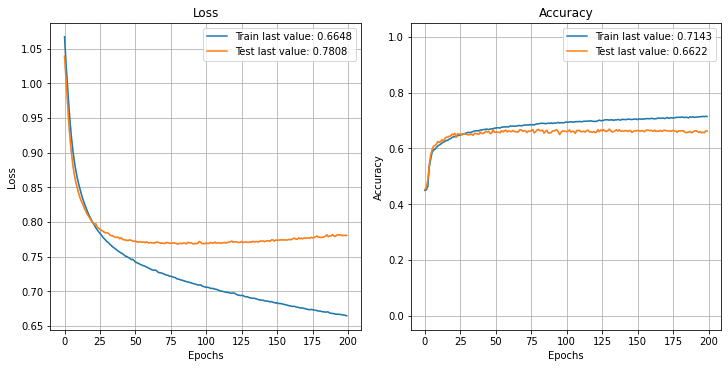

In [ ]:
# your code goes here

history = model_3_1.fit(x = [x_train_review_pad_glove, x_train_aspect_pad_glove],
                        y= y_train,
                        epochs =200,
                        batch_size= 512,
                        validation_data=([x_dev_review_pad_glove, x_dev_aspect_pad_glove], y_dev),
                        verbose=1)

results = model_3_1.evaluate([x_test_review_pad_glove, x_test_aspect_pad_glove], y_test)
print(results)
plot_history(history.history, path="std.png")
plt.show()

## Model 3-2 CNN or LSTM model with multiple-input

Modify the previous CNN or LSTM model to be compatible with multiple-input, similar to model 3-1. 

LSTM

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_26[0][0]',               
                                                                  'input_27[0][0]']               
                                                                                                  
 lstm_9 (LSTM)                  (None, 100)          160400      ['GloVe_Embeddings[0][0]']

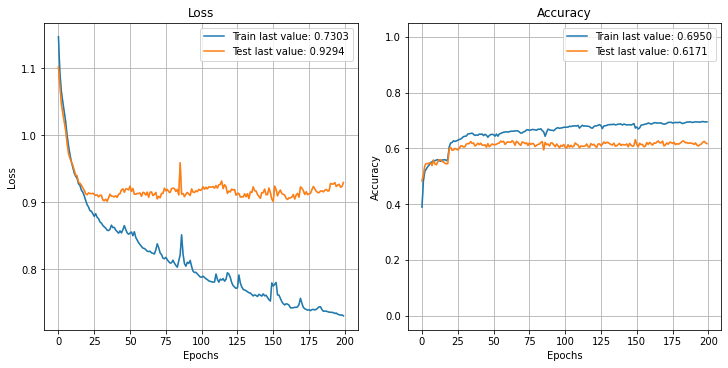

In [ ]:
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

# your code goes here
from keras.layers import Input, Dense,concatenate , LSTM
from keras.models import Model

MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100


input_layer_1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_layer_2 = Input(shape=(16,))

#Right side Input model
embedding_layer_1 = embeddingLayer(input_layer_1)
LSTM_layer_1 = LSTM(EMBEDDING_SIZE, return_sequences=False)(embedding_layer_1)
hidden_dense_layer_1 = Dense(16, activation='relu')(LSTM_layer_1)
output_dense_layer_1 = Dense(3, activation='softmax')(hidden_dense_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)

#Left side Input model
embedding_layer_2 = embeddingLayer(input_layer_2)
LSTM_layer_2 = LSTM(EMBEDDING_SIZE, return_sequences=False)(embedding_layer_2)
hidden_dense_layer_2 = Dense(16, activation='relu')(LSTM_layer_2)
output_dense_layer_2 = Dense(3, activation='softmax')(hidden_dense_layer_2)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

# concatenating output
combined_layer = concatenate([model_1.output, model_2.output])


output_dense_layer = Dense(3, activation='softmax')(combined_layer)

model_3_2 = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
model_3_2.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_3_2.summary()

history = model_3_2.fit(x = [x_train_review_pad_glove, x_train_aspect_pad_glove],
                        y= y_train,
                        epochs =200,
                        batch_size= 512,
                        validation_data=([x_dev_review_pad_glove, x_dev_aspect_pad_glove], y_dev),
                        verbose=1)

results = model_3_2.evaluate([x_test_review_pad_glove, x_test_aspect_pad_glove], y_test)
print(results)
plot_history(history.history, path="std.png")
plt.show()




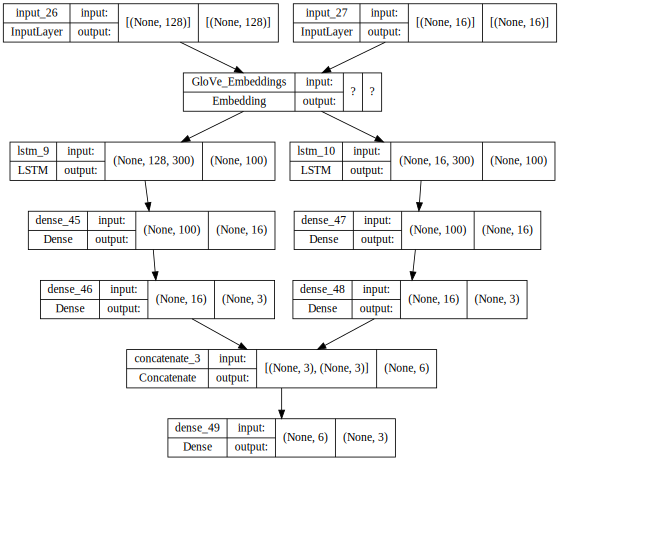

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_3_2, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

CNN

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_30[0][0]',               
                                                                  'input_31[0][0]']               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 123, 100)     180100      ['GloVe_Embeddings[0][0]']

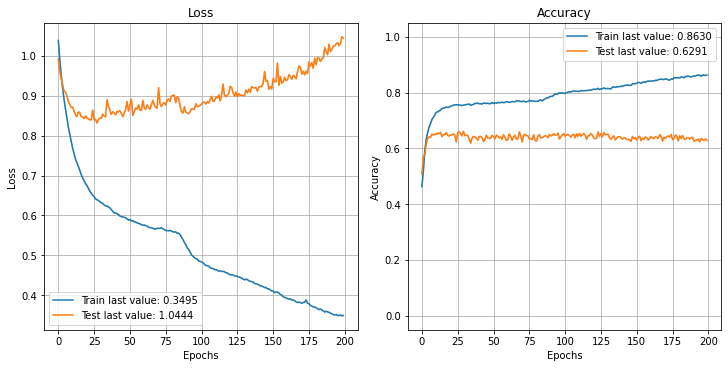

In [ ]:
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

# your code goes here
from keras.layers import Input, Dense,concatenate , Conv1D, GlobalMaxPool1D
from keras.models import Model

MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100


input_layer_1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_layer_2 = Input(shape=(16,))

#Right side Input model
embedding_layer_1 = embeddingLayer(input_layer_1)
conv_layer_1 = Conv1D(EMBEDDING_SIZE,6)(embedding_layer_1)
maxPooling_layer_1 = GlobalMaxPool1D()(conv_layer_1)
hidden_dense_layer_1 = Dense(16, activation='relu')(maxPooling_layer_1)
output_dense_layer_1 = Dense(3, activation='softmax')(hidden_dense_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)

#Left side Input model
embedding_layer_2 = embeddingLayer(input_layer_2)
conv_layer_2 = Conv1D(EMBEDDING_SIZE,6)(embedding_layer_2)
maxPooling_layer_2 = GlobalMaxPool1D()(conv_layer_2)
hidden_dense_layer_2 = Dense(16, activation='relu')(maxPooling_layer_2)
output_dense_layer_2 = Dense(3, activation='softmax')(hidden_dense_layer_2)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

# concatenating output
combined_layer = concatenate([model_1.output, model_2.output])


output_dense_layer = Dense(3, activation='softmax')(combined_layer)

model_3_2 = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
model_3_2.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_3_2.summary()

history = model_3_2.fit(x = [x_train_review_pad_glove, x_train_aspect_pad_glove],
                        y= y_train,
                        epochs =200,
                        batch_size= 512,
                        validation_data=([x_dev_review_pad_glove, x_dev_aspect_pad_glove], y_dev),
                        verbose=1)

results = model_3_2.evaluate([x_test_review_pad_glove, x_test_aspect_pad_glove], y_test)
print(results)
plot_history(history.history, path="std.png")
plt.show()




CNN is doing a better job with 4% accuracy advantage

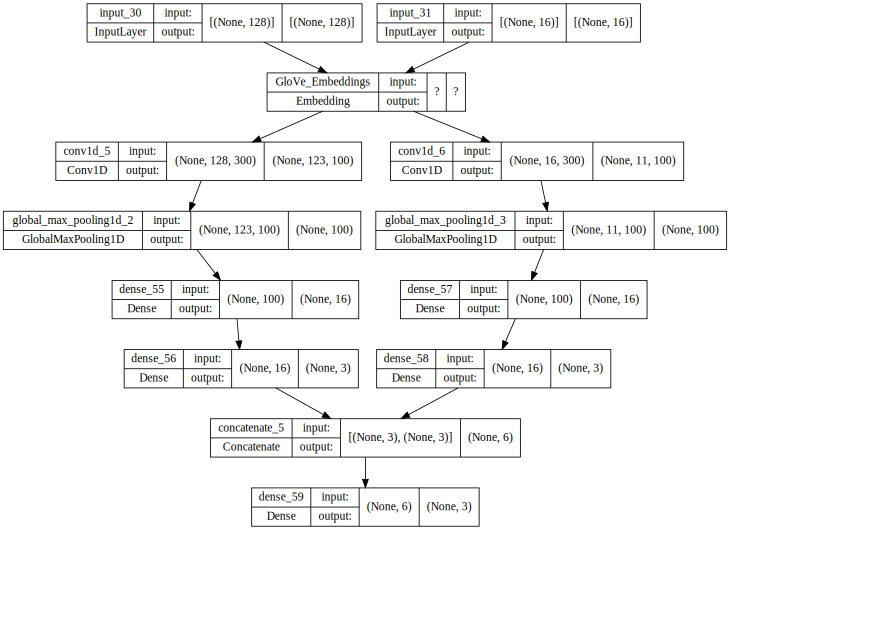

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_3_2, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

#  Model 4: Another LSTM model

If you study the data carefully, you can find that every aspect appears in the review sentence, which means we can extract the aspect information from the sentence. In most cases, the polarity of the aspect is determined by the content near it. Therefore, an LSTM can transfer the information of adjacent context to the aspect. We only need to extract the aspect vector to calculate its polarity, without analyzing the whole sentence.

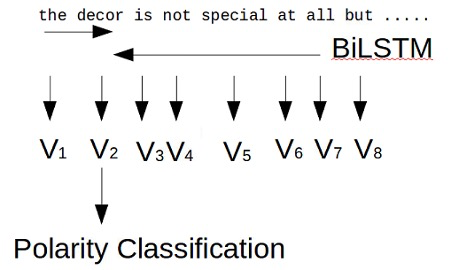

(This is a bit like a simplified version of the "unknown target" sequence tagging models discussed in lectures - but we're only trying to tag the one part of the sequence that we know corresponds to the aspect mention.)

In [ ]:
def aspect_mask(reviews, aspects, dataset):
  mask = []
  for review,aspect,data in zip(reviews, aspects, dataset):
    find_aspect = False
    for j in range(5):
      aspect_num = len(aspect)
      aspect_str = " ".join(aspect)
      aspect_len = int(len(aspect_str) - 1) * (j+1)
      offset = 0
      for i,r in enumerate(review):
        if i + aspect_num <= len(review):
          r_context = " ".join(review[i:i+aspect_num])
          if r_context == aspect_str and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
            find_aspect = True
            sentence_mask = [0] * len(review)
            sentence_mask[i:i+aspect_num] = [1] * aspect_num
            mask.append(sentence_mask)
            break
          else:
            offset += (len(r) + 1)
      if find_aspect:
        break

    if not find_aspect:
      for j in range(5):
        aspect_len = int(len(aspect_str) - 1) * (j+1)
        offset = 0
        for i,r in enumerate(review):
          if i + aspect_num <= len(review):
            r_context = " ".join(review[i:i+aspect_num])
            if r_context.startswith(aspect_str) and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
              find_aspect = True
              sentence_mask = [0] * len(review)
              sentence_mask[i:i+aspect_num] = [1] * aspect_num
              mask.append(sentence_mask)
              break
            else:
              offset += (len(r) + 1)
        if find_aspect:
          break

    if not find_aspect:
      for j in range(5):
        aspect_len = int(len(aspect_str) - 1) * (j+1)
        offset = 0
        for i,r in enumerate(review):
          if i + aspect_num <= len(review):
            r_context = " ".join(review[i:i+aspect_num])
            if r_context.endswith(aspect_str) and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
              find_aspect = True
              sentence_mask = [0] * len(review)
              sentence_mask[i:i+aspect_num] = [1] * aspect_num
              mask.append(sentence_mask)
              break
            else:
              offset += (len(r) + 1)
        if find_aspect:
          break

    if not find_aspect:
      print("annotation error:")
      print(data)
      sentence_mask = [0] * len(review)
      sentence_mask[16] = 1
      mask.append(sentence_mask)

    # if aspect_num > 1:
    #   print(mask[-1])

  return mask
x_train_aspect_mask = aspect_mask(x_train_review, x_train_aspect, train)
x_dev_aspect_mask = aspect_mask(x_dev_review, x_dev_aspect, val)
x_test_aspect_mask = aspect_mask(x_test_review, x_test_aspect, test)

print()
print()
print()
assert len(x_train_aspect_mask) == len(train)
assert len(x_test_aspect_mask) == len(x_test_aspect)

print(train[0])
print(x_train_aspect_mask[0])
print(train[1])
print(x_train_aspect_mask[1])
print(train[2])
print(x_train_aspect_mask[2])
print(train[3])
print(x_train_aspect_mask[3])
print(train[10319])
print(x_train_aspect_mask[10319])

annotation error:
['i love the food here, and although it is pricey, the entree comes with rice, naan, dal, and salad, which makes it worthwhile.', 'd al', 'neutral', '24', '28']



['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the scene there are two distinct personalities to the place: the loud, seemingly always-crowded bar with hanging paper decorations and dim lighting, and the two main dinin

In [ ]:
x_train_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_train_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_dev_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_dev_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_test_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_test_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_train_aspect_mask_pad[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
import tensorflow as tf

# your code goes here
# Tips: 
# 1) LSTM layer: Bidirectional(LSTM(100, return_sequences=True),name = 'BiLSTM')
# 2) Dot  layer: tf.keras.layers.Dot(axes=1)
# 3) Document of the Dot layer: https://keras.io/api/layers/merging_layers/dot/
# 4) dtype of the aspect input layer is float32

from keras.layers import Input, Bidirectional, Dense, LSTM, Dot
from keras.models import Model

MAX_SEQUENCE_LENGTH = 128
EMBEDDING_SIZE = 100

#First Input
input_layer_1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer_1 = embeddingLayer(input_layer_1)
lstm_layer_1 = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True), name='BiLSTM')(embedding_layer_1)
model_review = Model(input_layer_1,lstm_layer_1)


#Second Input
input_layer_2 = Input(shape=(MAX_SEQUENCE_LENGTH,))
dot_layer = Dot(axes=1)([model_review.output, input_layer_2])
dense_layer = Dense(16, activation='relu')(dot_layer)
output_dense_layer = Dense(3, activation='softmax')(dense_layer)

model_5 = Model(inputs=[model_review.input, input_layer_2], outputs = output_dense_layer)
model_5.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_5.summary()


Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_36[0][0]']               
                                                                                                  
 BiLSTM (Bidirectional)         (None, 128, 200)     320800      ['GloVe_Embeddings[4][0]']       
                                                                                                  
 input_37 (InputLayer)          [(None, 128)]        0           []                               
                                                                                           

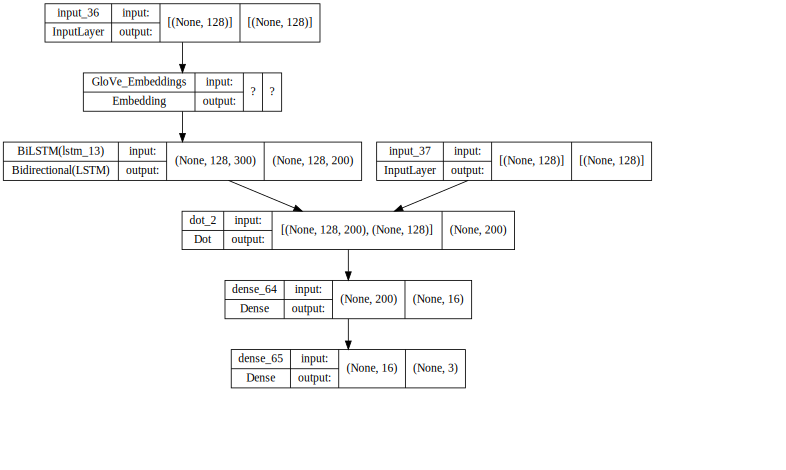

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_5, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Epoch 1/16
22/22 [==============================] - 4s 84ms/step - loss: 0.9854 - accuracy: 0.5076 - val_loss: 0.8707 - val_accuracy: 0.6329
Epoch 2/16
22/22 [==============================] - 1s 51ms/step - loss: 0.8223 - accuracy: 0.6398 - val_loss: 0.7770 - val_accuracy: 0.6772
Epoch 3/16
22/22 [==============================] - 1s 51ms/step - loss: 0.7295 - accuracy: 0.6891 - val_loss: 0.7212 - val_accuracy: 0.7057
Epoch 4/16
22/22 [==============================] - 1s 51ms/step - loss: 0.6699 - accuracy: 0.7194 - val_loss: 0.7029 - val_accuracy: 0.7155
Epoch 5/16
22/22 [==============================] - 1s 51ms/step - loss: 0.6239 - accuracy: 0.7403 - val_loss: 0.7005 - val_accuracy: 0.7222
Epoch 6/16
22/22 [==============================] - 1s 51ms/step - loss: 0.5813 - accuracy: 0.7611 - val_loss: 0.6747 - val_accuracy: 0.7282
Epoch 7/16
22/22 [==============================] - 1s 51ms/step - loss: 0.5340 - accuracy: 0.7871 - val_loss: 0.6552 - val_accuracy: 0.7365
Epoch 8/16
22

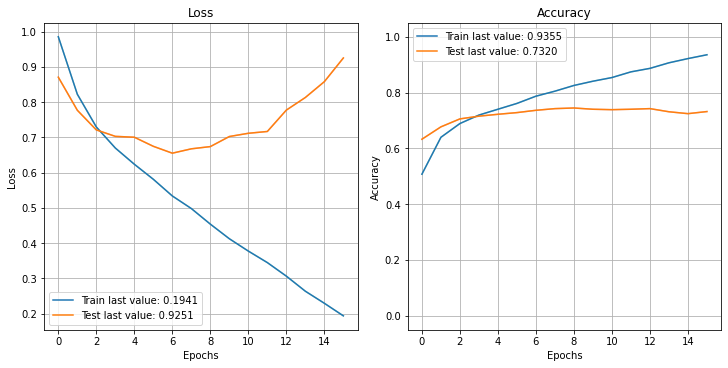

In [ ]:
# your code goes here
final_history = model_5.fit(x = [x_train_review_pad_glove, x_train_aspect_mask_pad],
                    y = y_train,
                    epochs=16,
                    batch_size=512,
                    validation_data=([x_dev_review_pad_glove, x_dev_aspect_mask_pad], y_dev),
                    verbose=1)
results = model_5.evaluate([x_test_review_pad_glove, x_test_aspect_mask_pad], y_test)
print(results)
plot_history(final_history.history, path="std.png")
plt.show()